In [1]:
%matplotlib inline
import sys 
import numpy as np
import h5py 
import matplotlib.pyplot as plt
import time
import datetime
import os
import tensorflow as tf
from tensorflow.python import control_flow_ops
import math

In [2]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))

In [3]:
'''Convert class labels from scalars to one-hot vectors.'''
def dense_to_one_hot(labels_dense, num_classes=10):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes), dtype=np.float32)
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [130]:
## for minist
hf = h5py.File('../data/mnist.hdf5','r')
print('datasets: {}'.format(hf.keys()))

n_class     = 10
width_size  = 28
height_size = 28
area_size   = width_size * height_size

trainingSize = hf['x_train'].shape[0]
validationSize = hf['x_valid'].shape[0]
testSize = hf['x_test'].shape[0]

batch_size = 200

datasets: [u't_test', u't_train', u't_valid', u'x_test', u'x_train', u'x_valid']


In [4]:
hf = h5py.File('../data/cifar-10.hdf5','r')
print('datasets: {}'.format(hf.keys()))

#x_train = theano.shared(hf['x_train'][()])
#t_train = theano.shared(dense_to_one_hot(np.array(hf['t_train'][()])))
#x_valid = theano.shared(hf['x_valid'][()])
#t_valid = theano.shared(dense_to_one_hot(np.array(hf['t_valid'][()])))
#x_test  = theano.shared(hf['x_test'][()])
#t_test  = theano.shared(dense_to_one_hot(np.array(hf['t_test'][()])))

n_class     = 10
width_size  = 32
height_size = 32
area_size   = width_size * height_size * 3
trainingSize = hf['train_set_x'].shape[0]
validationSize = hf['valid_set_x'].shape[0]
testSize = hf['test_set_x'].shape[0]

print trainingSize, validationSize, testSize

batch_size = 200
C_val = 0.001

datasets: [u'test_set_x', u'test_set_y', u'train_set_x', u'train_set_y', u'valid_set_x', u'valid_set_y']
40000 10000 10000


In [131]:
"""
datasets = load_data(dataset)

train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]
"""
# compute number of minibatches for training, validation and testing
batch_size = 200
n_train_batches = trainingSize
n_valid_batches = validationSize
n_test_batches = testSize
n_train_batches /= batch_size
n_valid_batches /= batch_size
n_test_batches /= batch_size

print '[size of each set]'
print ('training_set : %d, valid_set : %d, test_set : %d' %(hf['train_set_x'].shape[0], hf['valid_set_x'].shape[0], hf['test_set_x'].shape[0]))
print '[size of each batch]'
print ('training_set : %d, valid_set : %d, test_set : %d' %(n_train_batches, n_valid_batches, n_test_batches))

[size of each set]


KeyError: "Unable to open object (Object 'train_set_x' doesn't exist)"

In [ ]:
conv1_n_param = [3, 3, 3, 32]
poo11_n_param = (2, 2)
conv2_n_param = [3, 3, 32, 64]
pool2_n_param = (2, 2)

conv3_n_param = [5, 5, 64, 128]
pool3_n_param = (2, 2)
conv4_n_param = [3, 3, 128, 64]
pool4_n_param = (4, 4)

fc1_n_param = [1 * 1 * 64, 2]
fc2_n_param = [2, n_class]

In [6]:
sess = tf.InteractiveSession()

In [7]:
def calc_moments(x, mode):
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var_with_update():
                with tf.control_dependencies([ema_apply_op]):
                    return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(mode,
        mean_var_with_update,
        lambda: (ema_mean, ema_var))
    return mean, var

In [8]:
def var_loss_fc(features, labels, idx, mode):
    locs = tf.where(tf.equal(labels, idx))
    batch_mean, batch_var = tf.nn.moments(tf.gather(features, locs), [0], name='moments_fc')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var_with_update():
                with tf.control_dependencies([ema_apply_op]):
                    return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(mode,
        mean_var_with_update,
        lambda: (ema_mean, ema_var))
    return mean, var
    #intra_loss = tf.reduce_sum(intra_var)

In [9]:
def var_loss_cnn(features, labels, idx):
    locs = tf.where(tf.equal(labels, idx))
    intra_mean, intra_var = tf.nn.moments(tf.gather(features, locs), [0,1], name='moments_cnn')
    #intra_loss = tf.reduce_sum(intra_var)

In [80]:
def clac_layerwise_loss(moments, size):
    var_list = []
    for i in range (0, n_class):
        var_list.append(moments[i][1])
    packed_intra = tf.pack(var_list)  
    packed_intra = tf.reshape(packed_intra, [n_class, size])
    #print packed_intra.get_shape()
    intra_var_loss = tf.reduce_sum(packed_intra)
    #print hid_layer_1_losses.get_shape()
    #print moments[0][0]
    #print moments[0][0].get_shape()
    mean_list = []
    for i in range (0, n_class):
        mean_list.append(moments[i][0])
    packed = tf.pack(mean_list)
    packed = tf.reshape(packed, [n_class, size])
    packed_mean, packed_var = tf.nn.moments(packed, [0], name = 'moments_fc_total')
    #print packed_var.get_shape()
    inter_var_loss = tf.reduce_sum(packed_var)
    layer_loss = intra_var_loss / inter_var_loss
    return layer_loss

In [128]:
x = tf.placeholder("float", shape=[None, 32, 32, 3])
y_ = tf.placeholder("float", shape=[None, n_class])
y_scalar = tf.placeholder("float", shape=[None])
dummy_bool = tf.placeholder(tf.bool, name='phase_train')

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.02)
    return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.constant(0.02, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x, stride):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, stride, stride, 1], padding='SAME')
def max_pool_4x4(x, stride):
    return tf.nn.max_pool(x, ksize=[1, 4, 4, 1],
                        strides=[1, stride, stride, 1], padding='VALID')

#x_ = tf.reshape(x, [-1, 32, 32, 1])
W_conv1 = weight_variable(conv1_n_param)
b_conv1 = bias_variable([conv1_n_param[-1]])
feature_ly1 = conv2d(x, W_conv1, 1) + b_conv1
moments_cv1 = [var_loss_fc(feature_ly1, y_scalar, idx, dummy_bool) for idx in range(0, n_class)]
cv1_loss = clac_layerwise_loss(moments_cv1, conv1_n_param[-1] *32 * 32)
h_conv1 = tf.nn.relu(feature_ly1)
h_pool1 = max_pool_2x2(h_conv1, 2)

W_conv2 = weight_variable(conv2_n_param)
b_conv2 = bias_variable([conv2_n_param[-1]])
feature_ly2 = conv2d(h_pool1, W_conv2, 1) + b_conv2
moments_cv2 = [var_loss_fc(feature_ly2, y_scalar, idx, dummy_bool) for idx in range(0, n_class)]
cv2_loss = clac_layerwise_loss(moments_cv2, conv2_n_param[-1] *16 * 16)
h_conv2 = tf.nn.relu(feature_ly2)
h_pool2 = max_pool_2x2(h_conv2, 2)

W_conv3 = weight_variable(conv3_n_param)
b_conv3 = bias_variable([conv3_n_param[-1]])
feature_ly3 = conv2d(h_pool2, W_conv3, 1) + b_conv3
moments_cv3 = [var_loss_fc(feature_ly3, y_scalar, idx, dummy_bool) for idx in range(0, n_class)]
cv3_loss = clac_layerwise_loss(moments_cv3, conv3_n_param[-1] *8 * 8)
h_conv3 = tf.nn.relu(feature_ly3)
h_pool3 = max_pool_2x2(h_conv3, 2)

W_conv4 = weight_variable(conv4_n_param)
b_conv4 = bias_variable([conv4_n_param[-1]])
feature_ly4 = conv2d(h_pool3, W_conv4, 1) + b_conv4
h_conv4 = tf.nn.relu(feature_ly4)
moments_cv4 = [var_loss_fc(feature_ly4, y_scalar, idx, dummy_bool) for idx in range(0, n_class)]
cv4_loss = clac_layerwise_loss(moments_cv4, conv4_n_param[-1] * 4 * 4)
h_pool4 = max_pool_4x4(h_conv4, 1)
#print h_pool4.get_shape()[3]

h_pool4_flat = tf.reshape(h_pool4, [-1, fc1_n_param[0]])

W_fc1 = weight_variable(fc1_n_param)
b_fc1 = bias_variable([fc1_n_param[-1]])
w_sum_fc1 = tf.matmul(h_pool4_flat, W_fc1) + b_fc1
moments_fc1 = [var_loss_fc(w_sum_fc1, y_scalar, idx, dummy_bool) for idx in range(0, n_class)]
fc1_loss = clac_layerwise_loss(moments_fc1, fc1_n_param[-1])
h_fc1 = tf.nn.relu(w_sum_fc1)
locs = [tf.where(tf.equal(y_scalar, idx)) for idx in range(0, n_class)]

W_fc2 = weight_variable(fc2_n_param)
b_fc2 = bias_variable([fc2_n_param[-1]])
w_sum_fc2 = tf.matmul(h_fc1, W_fc2) + b_fc2
moments_fc2 = [var_loss_fc(w_sum_fc2, y_scalar, idx, dummy_bool) for idx in range(0, n_class)]
fc2_loss = clac_layerwise_loss(moments_fc2, fc2_n_param[-1])
h_fc2 = tf.nn.relu(w_sum_fc2)
output = tf.nn.softmax(h_fc2)
'''
w_sum_fc1 = tf.matmul(flat_x, W_fc1) + b_fc1
moments_fc1 = [var_loss_fc(w_sum_fc1, y_scalar, idx, dummy_bool) for idx in range(0, n_class)]
fc1_loss = clac_layerwise_loss(moments_fc1, fc1_n_param[-1])
hid_layer_1 = tf.nn.relu(w_sum_fc1)


#moment_mean, moment_var = tf.nn.moments(mean_list, [0], name='moments_fc_total')
#print moment_mean.get_shape()

W_fc2 = weight_variable(fc2_n_param)
b_fc2 = bias_variable([fc2_n_param[-1]])
w_sum_fc2 = tf.matmul(hid_layer_1, W_fc2) + b_fc2
moments_fc2 = [var_loss_fc(w_sum_fc2, y_scalar, idx, dummy_bool) for idx in range(0, n_class)]
fc2_loss = clac_layerwise_loss(moments_fc2, fc2_n_param[-1])
hid_layer_2 = tf.nn.softmax(w_sum_fc2)


W_fc3 = weight_variable(fc3_n_param)
b_fc3 = bias_variable([fc3_n_param[-1]])
hid_layer_3 = tf.nn.softmax(tf.matmul(hid_layer_2, W_fc3) + b_fc3)
'''
cross_entropy = -tf.reduce_sum(y_*tf.log(tf.clip_by_value(output, 1e-10, 1.0))) #loss는 최종 loss + 각 레이어의 var정보
loss = cross_entropy #+ cv4_loss ##+ fc2_loss + fc1_loss + cv2_loss + cv1_loss + cv3_loss + cv4_loss
train_step = tf.train.AdamOptimizer(1e-4).minimize( cross_entropy)#
#print y_*tf.log(tf.clip_by_value(hid_layer_3,1e-10,1.0)).get_shape()
correct_prediction = tf.equal(tf.argmax(output,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


#batch_mean, batch_var = tf.reduce_mean(tf.gather(x, locs), 0)
#batch_mean, batch_var = tf.nn.moments(tf.gather(x, locs), [0], name='moments')

sess.run(tf.initialize_all_variables())


In [12]:
start_Idx = 0
end_Idx = 300

x_train = np.array(hf['train_set_x'][start_Idx:end_Idx])
y_train = dense_to_one_hot(np.array(hf['train_set_y'][start_Idx:end_Idx]))
y_train_s = np.array(hf['train_set_y'][start_Idx:end_Idx])
#x_train = np.array(hf['x_train'][start_Idx:end_Idx]).reshape(300,28,28,1)
#y_train = dense_to_one_hot(np.array(hf['t_train'][start_Idx:end_Idx]))
#y_train_s = np.array(hf['t_train'][start_Idx:end_Idx])

In [15]:
import matplotlib.cm as cm

In [29]:
locIdx = []
for idx in range(0, n_class):
    locIdx.append(locs[idx].eval(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False}))

4.01781
0.223333


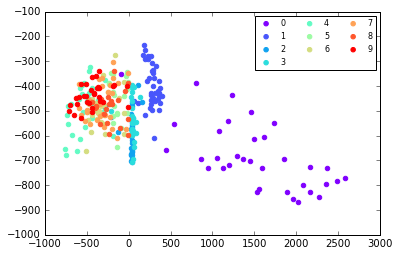

In [127]:
for idx in range(0, 300):
    train_step.run(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False})

#print W_fc1.eval()
print fc1_loss.eval(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False})
print accuracy.eval(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False})
#print moments_fc1[0][1].eval(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False})

##plot

res = w_sum_fc1.eval(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False})

colors = cm.rainbow(np.linspace(0, 1, len(locIdx)))
plts = []
for idx in range(0, n_class):
    plts.append(plt.scatter(res[locIdx[idx],0],res[locIdx[idx],1],color=colors[idx]))
    
plt.legend((plts[0], plts[1], plts[2], plts[3], plts[4], plts[5], plts[6], plts[7], plts[8], plts[9]),
       ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'),
       scatterpoints=1,
       loc='upper right',
       ncol=3,
       fontsize=8)
plt.show()

In [13]:
res_dir = datetime.datetime.now().isoformat() + '_var_loss_CNN_cifar10_color_test_cross_cv4loss'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

In [129]:
###############
# TRAIN MODEL #
###############

t_next = time.time()
t_prev = time.time()

patience = 10000  # look as this many examples regardless
validation_frequency = min(n_train_batches, patience / 2)
epoch_size = 50
col_count = area_size
startIdx = 0
endIdx = batch_size
k = 0

accuracy_train = 0
valid_accuracy = 0
test_accuracy = 0
while (k <= epoch_size):
    k = k + 1
    start_Idx = 0
    end_Idx = batch_size
    accuracy_train = 0
    for minibatch_index in xrange(n_train_batches): #per epoch
        iter = (k - 1) * n_train_batches + minibatch_index
        x_train = np.array(hf['train_set_x'][start_Idx:end_Idx])
        x_train = np.rollaxis(x_train,1,4)
        #print x_train.shape
        y_train_s = np.array(hf['train_set_y'][start_Idx:end_Idx])
        y_train = dense_to_one_hot(y_train_s)
        
        start_Idx = end_Idx
        end_Idx = end_Idx + batch_size
        train_step.run(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False})
        accuracy_train = accuracy_train + accuracy.eval(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False})
        #accuracy_train /= minibatch_index + 1
        if end_Idx % 10000 == 0:            
            print('%d/%d epoch, @iter = %d/%d, training accuracy : %.5f' %(k, epoch_size, end_Idx, trainingSize, accuracy_train/(minibatch_index + 1)))
        
        if (iter + 1) % validation_frequency == 0:
            loss_fc1 = fc1_loss.eval(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False})
            loss_cv1 = cv1_loss.eval(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False})
            loss_cv2 = cv2_loss.eval(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False})
            loss_cv3 = cv3_loss.eval(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False})
            loss_cv4 = cv4_loss.eval(feed_dict={x: x_train, y_: y_train, y_scalar: y_train_s, dummy_bool: False})
            
            print('<<<<<epoch %i, minibatch %i/%i, training accuracy %.5f, cv1 %.2f, cv2 %.2f, cv3 %.2f, cv4 %.2f, fc1 %.2f>>>>>' %
                  (k, minibatch_index + 1, n_train_batches,
                   accuracy_train/(minibatch_index + 1), loss_cv1, loss_cv2, loss_cv3, loss_cv4, loss_fc1))
            # compute zero-one loss on validation set
            start_Idx_valid = 0
            end_Idx_valid = batch_size
            valid_loss = 0;
            valid_accuracy = 0
            for valid_minibatch in xrange(n_valid_batches):
                x_valid = np.array(hf['valid_set_x'][start_Idx_valid:end_Idx_valid])
                x_valid = np.rollaxis(x_valid,1,4)
                y_valid_s = np.array(hf['valid_set_y'][start_Idx_valid:end_Idx_valid])
                y_valid = dense_to_one_hot(y_valid_s)
                start_Idx_valid  = end_Idx_valid
                end_Idx_valid = end_Idx_valid + batch_size               
                valid_accuracy = valid_accuracy + accuracy.eval(feed_dict={x: x_valid, y_: y_valid, y_scalar: y_valid_s, dummy_bool: False})

            valid_accuracy = valid_accuracy / n_valid_batches
            print('epoch %i, minibatch %i/%i, valid accuracy %.5f' %
                  (k, minibatch_index + 1, n_train_batches, valid_accuracy))

            # test it on the test set
            start_Idx_test = 0
            end_Idx_test = batch_size
            test_loss = 0
            test_accuracy = 0
            for test_minibatch in xrange(n_test_batches):
                x_test = np.array(hf['test_set_x'][start_Idx_test:end_Idx_test])
                x_test = np.rollaxis(x_test,1,4)
                y_test_s = np.array(hf['test_set_y'][start_Idx_test:end_Idx_test])
                y_test= dense_to_one_hot(y_test_s)
                start_Idx_test  = end_Idx_test
                end_Idx_test= end_Idx_test + batch_size
                test_accuracy = test_accuracy + accuracy.eval(feed_dict={x: x_test, y_: y_test, y_scalar: y_test_s, dummy_bool: False})

            test_score = test_loss / n_test_batches
            test_accuracy = test_accuracy / n_test_batches
            print('     epoch %i, minibatch %i/%i, test accuracy %.5f' %
                      (k, minibatch_index + 1, n_train_batches, test_accuracy))
            
            f = open(res_dir + '/status_training.txt', 'a')
            f.write("epoch %d, training accuracy %.5f, valid accuracy : %.5f, test accuracy: %.5f, cv1 %.2f, cv2 %.2f, cv3 %.2f, cv4 %.2f, fc1 %.2f\n"%(k, 
                        accuracy_train/(minibatch_index + 1), valid_accuracy, test_accuracy, loss_cv1, loss_cv2, loss_cv3, loss_cv4, loss_fc1))
            f.close()

NameError: name 'n_train_batches' is not defined